In [1]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import tensorflow.keras.backend as K
import zipfile
import pandas as pd

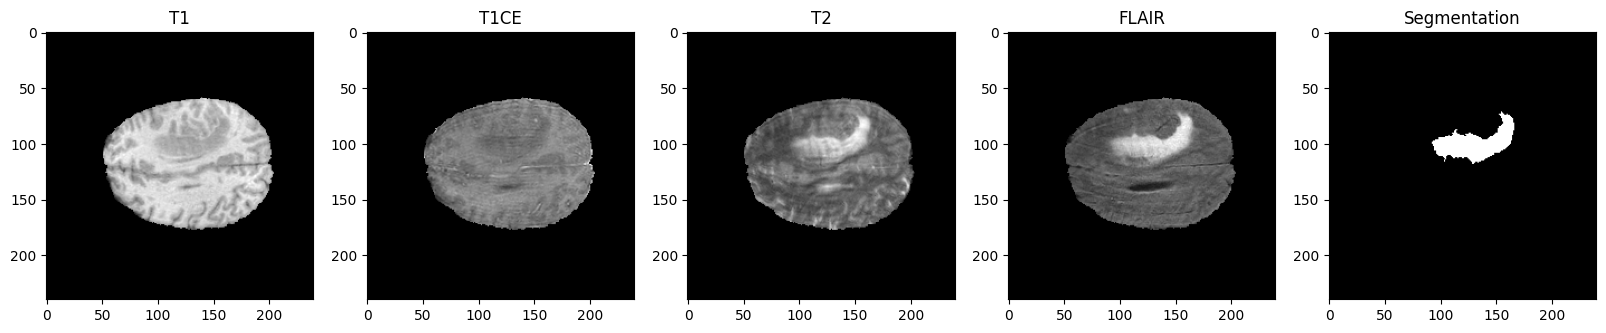

In [2]:
# Specify a sample path (here we will take the first patient of the Training dataset)
sample_path = '/Users/kaiser/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'

# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_img=nib.load(sample_path + 't1.nii')
t1ce_img=nib.load(sample_path + 't1ce.nii')
t2_img=nib.load(sample_path + 't2.nii')
flair_img=nib.load(sample_path + 'flair.nii')
seg_img=nib.load(sample_path + 'seg.nii')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot the 100th slice of the 4 RMI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

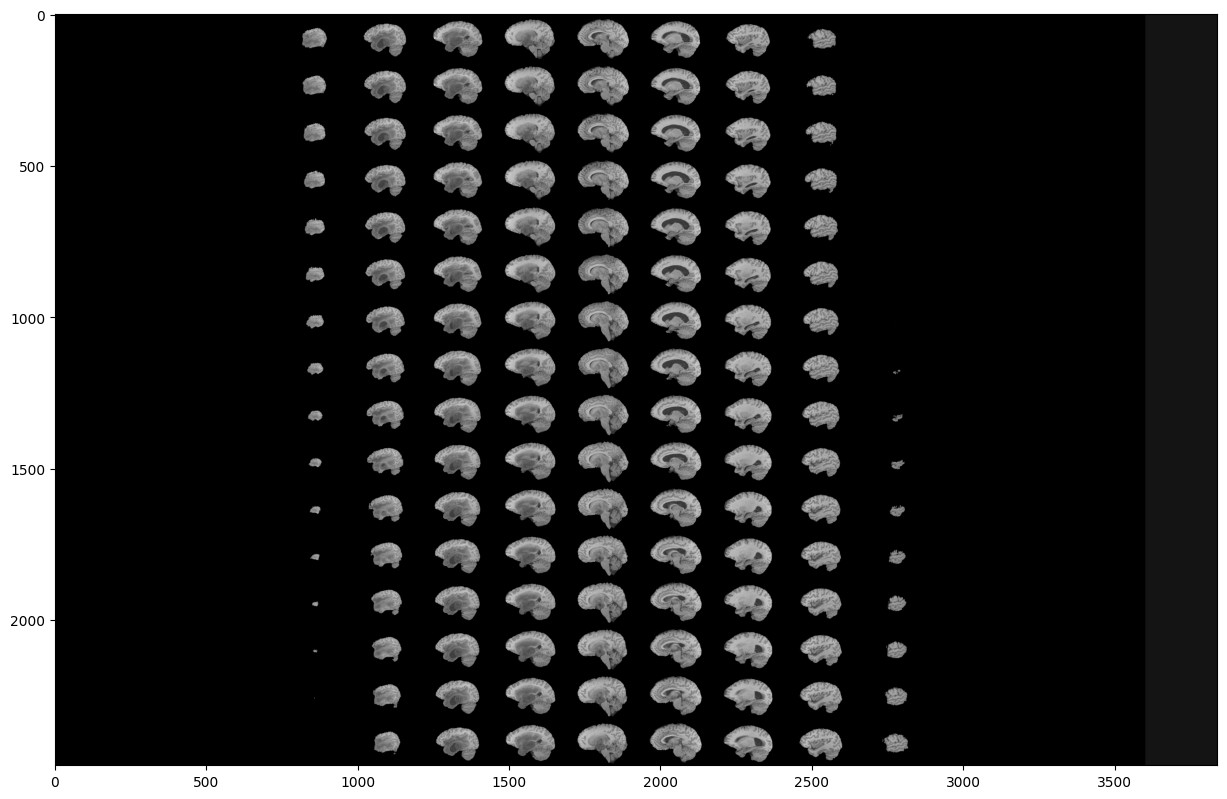

In [3]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[:,:,:]), 90, resize=True), cmap ='gray')

# montage allows us to concatenate multiple images of the same size horizontally and vertically

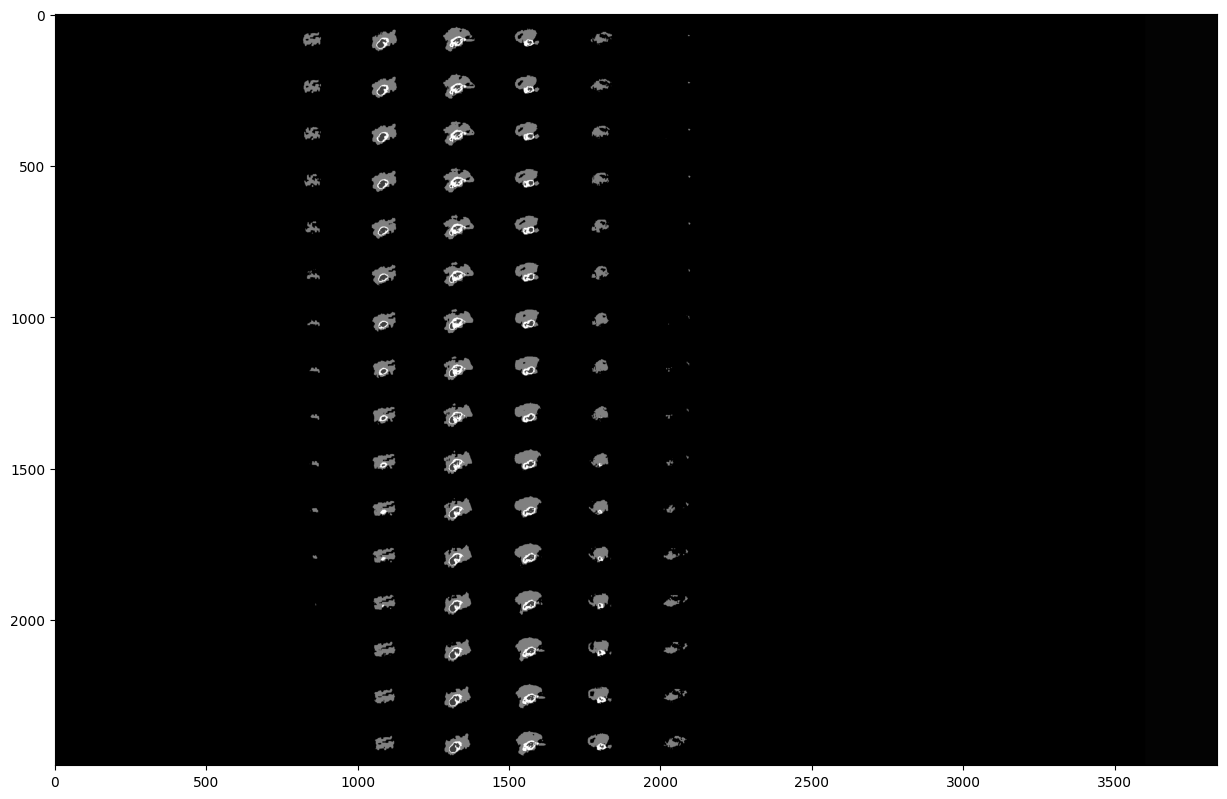

In [4]:
# Display all slices of a segmentation
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(seg_data[:,:,:]), 90, resize=True), cmap ='gray')

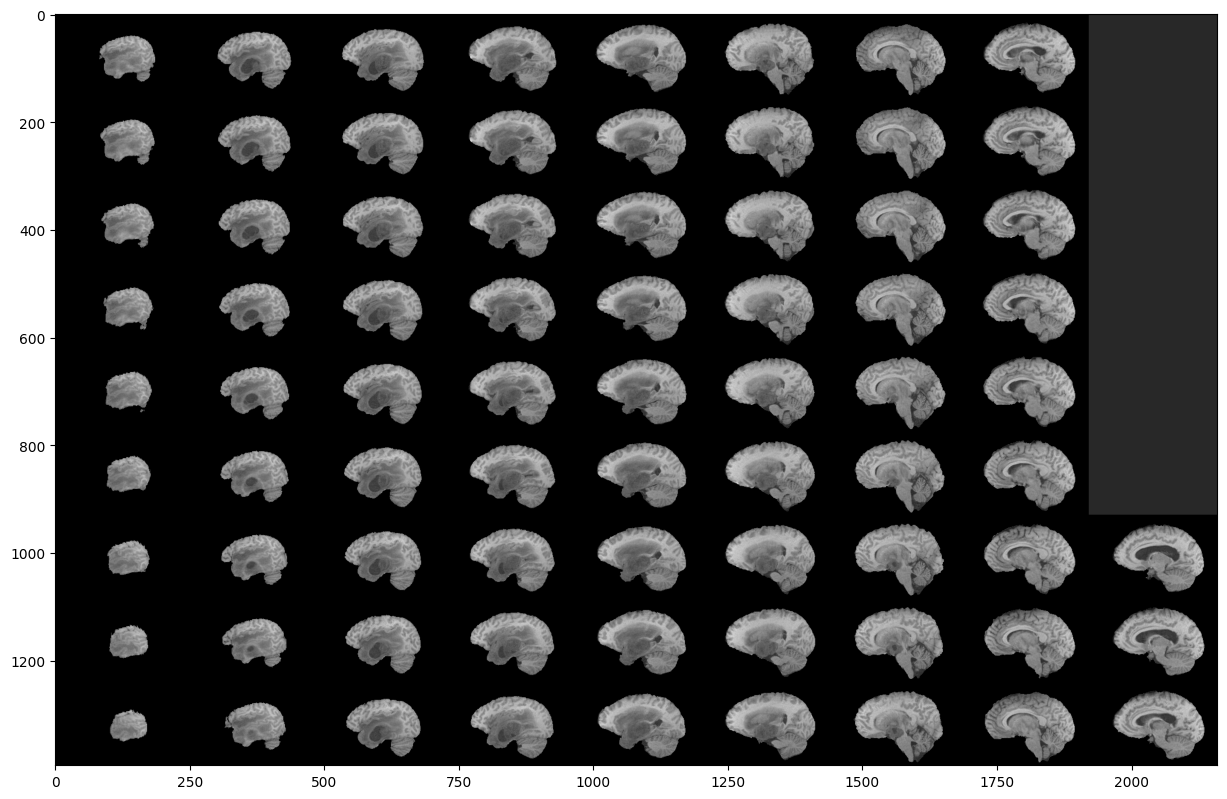

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[60:135,:,:]), 90, resize=True), cmap ='gray')

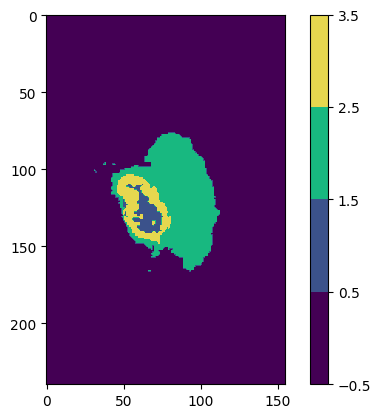

In [7]:
# Plot a segmantation
some_seg_img = nib.load('/Users/kaiser/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

In [10]:
data_path = "/Users/kaiser/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))
    
    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


In [11]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

[8716021   15443  168794   27742]


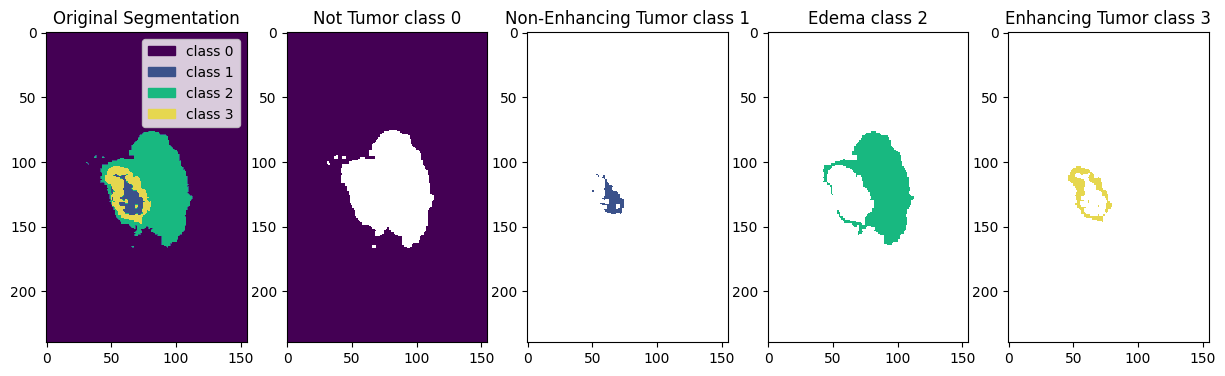

In [12]:
# Deletion of class 0
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.copy()
seg_3[seg_3 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3')

plt.show()

In [13]:
# Define selected slices range
VOLUME_START_AT = 60 
VOLUME_SLICES = 75 

In [15]:
data_path = "/Users/kaiser/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 371


In [16]:
samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

In [17]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set 
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


In [18]:
# DataGenerator from Rastislav's notebook, https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
IMG_SIZE = 128
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):
            
            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'
            #t1_path = sample_path + '_t1.nii'
            #t2_path = sample_path + '_t2.nii'
            
            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
                    
        # Masks / Segmentations
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/np.max(X), Y
        
training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

In [19]:
# U-Net implementation for BraTS 2019 by Naomi Fridman, https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

In [20]:
# Compute metric between the predicted segmentation and the ground truth
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [21]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )


In [22]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
    
    keras.callbacks.ModelCheckpoint(filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
                             verbose=1, save_best_only=True, save_weights_only=True),

    keras.callbacks.CSVLogger('training.log', separator=',', append=False)
]

In [29]:
keras.config.disable_traceback_filtering()

model.fit(training_generator,
          epochs=30,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9798 - dice_coef: 0.2962 - loss: 0.0796 - mean_io_u: 0.7235 - precision: 0.9822 - sensitivity: 0.9765 - specificity: 0.9941
Epoch 1: val_loss improved from 0.07072 to 0.06454, saving model to model_.01-0.064541.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2493s 10s/step - accuracy: 0.9798 - dice_coef: 0.2962 - loss: 0.0795 - mean_io_u: 0.7234 - precision: 0.9822 - sensitivity: 0.9765 - specificity: 0.9941 - val_accuracy: 0.9820 - val_dice_coef: 0.3044 - val_loss: 0.0645 - val_mean_io_u: 0.7576 - val_precision: 0.9860 - val_sensitivity: 0.9807 - val_specificity: 0.9953 - learning_rate: 0.0010
Epoch 2/30


2024-05-13 21:36:47.497166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.06454
250/250 ━━━━━━━━━━━━━━━━━━━━ 193s 771ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9820 - val_dice_coef: 0.3044 - val_loss: 0.0645 - val_mean_io_u: 0.7576 - val_precision: 0.9860 - val_sensitivity: 0.9807 - val_specificity: 0.9953 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9805 - dice_coef: 0.2924 - loss: 0.0929 - mean_io_u: 0.5766 - precision: 0.9818 - sensitivity: 0.9782 - specificity: 0.9939
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 3: val_loss did not improve from 0.06454
250/250 ━━━━━━━━━━━━━━━━━━━━ 2362s 9s/step - accuracy: 0.9805 - dice_coef: 0.2924 - loss: 0.0929 - mean_io_u: 0.5764 - precision: 0.9818 - sensitivity: 0.9782 - specificity: 0.9939 - val_accuracy: 0.9820 - val_dice_coef: 0.2699 - val_los

2024-05-13 22:19:22.773294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_loss did not improve from 0.06454
250/250 ━━━━━━━━━━━━━━━━━━━━ 187s 749ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9820 - val_dice_coef: 0.2699 - val_loss: 0.0754 - val_mean_io_u: 0.6914 - val_precision: 0.9819 - val_sensitivity: 0.9820 - val_specificity: 0.9940 - learning_rate: 2.0000e-04
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9805 - dice_coef: 0.2866 - loss: 0.0746 - mean_io_u: 0.6062 - precision: 0.9809 - sensitivity: 0.9802 - specificity: 0.9936
Epoch 5: val_loss improved from 0.06454 to 0.05812, saving model to model_.05-0.058118.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2433s 10s/step - accuracy: 0.9805 - dice_coef: 0.2866 - loss: 0.0746 - mean_io_u: 0.6063 - precision: 0.9809 - sensitivity: 0.9802 - specificity: 0.9936 - val_accuracy: 0.9821 - val_dice_coef: 0.3135 - val_loss: 0.0581 - val_mean_i

2024-05-13 23:03:02.936573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 6: val_loss did not improve from 0.05812
250/250 ━━━━━━━━━━━━━━━━━━━━ 189s 755ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9821 - val_dice_coef: 0.3135 - val_loss: 0.0581 - val_mean_io_u: 0.5256 - val_precision: 0.9862 - val_sensitivity: 0.9811 - val_specificity: 0.9954 - learning_rate: 2.0000e-04
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9804 - dice_coef: 0.3322 - loss: 0.0629 - mean_io_u: 0.5856 - precision: 0.9869 - sensitivity: 0.9765 - specificity: 0.9956
Epoch 7: val_loss improved from 0.05812 to 0.05531, saving model to model_.07-0.055314.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2506s 10s/step - accuracy: 0.9804 - dice_coef: 0.3322 - loss: 0.0628 - mean_io_u: 0.5856 - precision: 0.9869 - sensitivity: 0.9765 - specificity: 0.9956 - val_accuracy: 0.9836 - val_dice_coef: 0.3289 - val_loss: 0.0553 - val_mean_i

2024-05-13 23:47:57.784419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_loss did not improve from 0.05531
250/250 ━━━━━━━━━━━━━━━━━━━━ 184s 734ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9836 - val_dice_coef: 0.3289 - val_loss: 0.0553 - val_mean_io_u: 0.6179 - val_precision: 0.9901 - val_sensitivity: 0.9784 - val_specificity: 0.9966 - learning_rate: 2.0000e-04
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9830 - dice_coef: 0.3433 - loss: 0.0580 - mean_io_u: 0.6880 - precision: 0.9888 - sensitivity: 0.9778 - specificity: 0.9962
Epoch 9: val_loss improved from 0.05531 to 0.05008, saving model to model_.09-0.050081.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2418s 10s/step - accuracy: 0.9830 - dice_coef: 0.3433 - loss: 0.0580 - mean_io_u: 0.6879 - precision: 0.9888 - sensitivity: 0.9778 - specificity: 0.9962 - val_accuracy: 0.9852 - val_dice_coef: 0.3419 - val_loss: 0.0501 - val_mean_i

2024-05-14 00:31:19.487738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 10: val_loss did not improve from 0.05008
250/250 ━━━━━━━━━━━━━━━━━━━━ 182s 728ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9852 - val_dice_coef: 0.3419 - val_loss: 0.0501 - val_mean_io_u: 0.4200 - val_precision: 0.9891 - val_sensitivity: 0.9811 - val_specificity: 0.9963 - learning_rate: 2.0000e-04
Epoch 11/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9853 - dice_coef: 0.3675 - loss: 0.0470 - mean_io_u: 0.5274 - precision: 0.9909 - sensitivity: 0.9795 - specificity: 0.9968
Epoch 11: val_loss improved from 0.05008 to 0.04418, saving model to model_.11-0.044179.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2264s 9s/step - accuracy: 0.9852 - dice_coef: 0.3675 - loss: 0.0471 - mean_io_u: 0.5275 - precision: 0.9909 - sensitivity: 0.9795 - specificity: 0.9968 - val_accuracy: 0.9858 - val_dice_coef: 0.3582 - val_loss: 0.0442 - val_mean

2024-05-14 01:12:04.986282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 12: val_loss did not improve from 0.04418
250/250 ━━━━━━━━━━━━━━━━━━━━ 178s 711ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9858 - val_dice_coef: 0.3582 - val_loss: 0.0442 - val_mean_io_u: 0.6475 - val_precision: 0.9911 - val_sensitivity: 0.9803 - val_specificity: 0.9969 - learning_rate: 2.0000e-04
Epoch 13/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9839 - dice_coef: 0.3758 - loss: 0.0497 - mean_io_u: 0.5921 - precision: 0.9907 - sensitivity: 0.9772 - specificity: 0.9967
Epoch 13: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 13: val_loss did not improve from 0.04418
250/250 ━━━━━━━━━━━━━━━━━━━━ 2210s 9s/step - accuracy: 0.9839 - dice_coef: 0.3758 - loss: 0.0497 - mean_io_u: 0.5920 - precision: 0.9907 - sensitivity: 0.9772 - specificity: 0.9967 - val_accuracy: 0.9851 - val_dice_coef: 0.3685 -

2024-05-14 01:51:52.776149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 14: val_loss did not improve from 0.04418
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 715ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9851 - val_dice_coef: 0.3685 - val_loss: 0.0459 - val_mean_io_u: 0.6048 - val_precision: 0.9925 - val_sensitivity: 0.9780 - val_specificity: 0.9973 - learning_rate: 4.0000e-05
Epoch 15/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9861 - dice_coef: 0.3933 - loss: 0.0418 - mean_io_u: 0.6443 - precision: 0.9922 - sensitivity: 0.9797 - specificity: 0.9972
Epoch 15: val_loss improved from 0.04418 to 0.03864, saving model to model_.15-0.038635.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2212s 9s/step - accuracy: 0.9861 - dice_coef: 0.3933 - loss: 0.0418 - mean_io_u: 0.6443 - precision: 0.9922 - sensitivity: 0.9797 - specificity: 0.9972 - val_accuracy: 0.9872 - val_dice_coef: 0.3856 - val_loss: 0.0386 - val_mean

2024-05-14 02:31:43.979717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 16: val_loss did not improve from 0.03864
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 716ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9872 - val_dice_coef: 0.3856 - val_loss: 0.0386 - val_mean_io_u: 0.6479 - val_precision: 0.9926 - val_sensitivity: 0.9815 - val_specificity: 0.9974 - learning_rate: 4.0000e-05
Epoch 17/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9866 - dice_coef: 0.4011 - loss: 0.0400 - mean_io_u: 0.6340 - precision: 0.9926 - sensitivity: 0.9807 - specificity: 0.9973
Epoch 17: val_loss improved from 0.03864 to 0.03736, saving model to model_.17-0.037361.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2213s 9s/step - accuracy: 0.9866 - dice_coef: 0.4011 - loss: 0.0400 - mean_io_u: 0.6341 - precision: 0.9926 - sensitivity: 0.9807 - specificity: 0.9973 - val_accuracy: 0.9875 - val_dice_coef: 0.3944 - val_loss: 0.0374 - val_mean

2024-05-14 03:11:35.815722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 18: val_loss did not improve from 0.03736
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 715ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9875 - val_dice_coef: 0.3944 - val_loss: 0.0374 - val_mean_io_u: 0.6592 - val_precision: 0.9929 - val_sensitivity: 0.9819 - val_specificity: 0.9975 - learning_rate: 4.0000e-05
Epoch 19/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9863 - dice_coef: 0.4157 - loss: 0.0400 - mean_io_u: 0.6448 - precision: 0.9922 - sensitivity: 0.9803 - specificity: 0.9972
Epoch 19: val_loss improved from 0.03736 to 0.03697, saving model to model_.19-0.036974.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2210s 9s/step - accuracy: 0.9863 - dice_coef: 0.4157 - loss: 0.0400 - mean_io_u: 0.6448 - precision: 0.9922 - sensitivity: 0.9803 - specificity: 0.9972 - val_accuracy: 0.9878 - val_dice_coef: 0.3981 - val_loss: 0.0370 - val_mean

2024-05-14 03:51:24.621285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 20: val_loss improved from 0.03697 to 0.03697, saving model to model_.20-0.036974.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 178s 712ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9878 - val_dice_coef: 0.3981 - val_loss: 0.0370 - val_mean_io_u: 0.6049 - val_precision: 0.9940 - val_sensitivity: 0.9812 - val_specificity: 0.9978 - learning_rate: 4.0000e-05
Epoch 21/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9871 - dice_coef: 0.4146 - loss: 0.0379 - mean_io_u: 0.6426 - precision: 0.9928 - sensitivity: 0.9814 - specificity: 0.9974
Epoch 21: val_loss improved from 0.03697 to 0.03548, saving model to model_.21-0.035477.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2209s 9s/step - accuracy: 0.9871 - dice_coef: 0.4146 - loss: 0.0379 - mean_io_u: 0.6426 - precision: 0.9928 - sensitivity: 0.9814 - specificity: 0.9974 - val_accuracy: 0.9880 - 

2024-05-14 04:31:11.958143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 22: val_loss improved from 0.03548 to 0.03548, saving model to model_.22-0.035477.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 714ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9880 - val_dice_coef: 0.4076 - val_loss: 0.0355 - val_mean_io_u: 0.6622 - val_precision: 0.9927 - val_sensitivity: 0.9831 - val_specificity: 0.9974 - learning_rate: 4.0000e-05
Epoch 23/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9871 - dice_coef: 0.4143 - loss: 0.0371 - mean_io_u: 0.6673 - precision: 0.9926 - sensitivity: 0.9820 - specificity: 0.9974
Epoch 23: val_loss improved from 0.03548 to 0.03485, saving model to model_.23-0.034847.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2202s 9s/step - accuracy: 0.9871 - dice_coef: 0.4143 - loss: 0.0371 - mean_io_u: 0.6673 - precision: 0.9926 - sensitivity: 0.9820 - specificity: 0.9974 - val_accuracy: 0.9883 - 

2024-05-14 05:10:52.693485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 24: val_loss improved from 0.03485 to 0.03485, saving model to model_.24-0.034847.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 178s 713ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9883 - val_dice_coef: 0.4129 - val_loss: 0.0348 - val_mean_io_u: 0.6685 - val_precision: 0.9927 - val_sensitivity: 0.9838 - val_specificity: 0.9974 - learning_rate: 4.0000e-05
Epoch 25/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9875 - dice_coef: 0.4247 - loss: 0.0370 - mean_io_u: 0.6437 - precision: 0.9921 - sensitivity: 0.9830 - specificity: 0.9972
Epoch 25: val_loss improved from 0.03485 to 0.03467, saving model to model_.25-0.034667.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2205s 9s/step - accuracy: 0.9875 - dice_coef: 0.4247 - loss: 0.0370 - mean_io_u: 0.6437 - precision: 0.9921 - sensitivity: 0.9830 - specificity: 0.9972 - val_accuracy: 0.9883 - 

2024-05-14 05:50:36.160695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 26: val_loss improved from 0.03467 to 0.03467, saving model to model_.26-0.034667.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 716ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9883 - val_dice_coef: 0.4156 - val_loss: 0.0347 - val_mean_io_u: 0.7016 - val_precision: 0.9924 - val_sensitivity: 0.9839 - val_specificity: 0.9973 - learning_rate: 4.0000e-05
Epoch 27/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9879 - dice_coef: 0.4380 - loss: 0.0348 - mean_io_u: 0.7021 - precision: 0.9929 - sensitivity: 0.9830 - specificity: 0.9975
Epoch 27: val_loss improved from 0.03467 to 0.03416, saving model to model_.27-0.034162.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2206s 9s/step - accuracy: 0.9878 - dice_coef: 0.4380 - loss: 0.0348 - mean_io_u: 0.7021 - precision: 0.9929 - sensitivity: 0.9830 - specificity: 0.9975 - val_accuracy: 0.9886 - 

2024-05-14 06:30:20.936993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 28: val_loss improved from 0.03416 to 0.03416, saving model to model_.28-0.034162.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 178s 712ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9886 - val_dice_coef: 0.4169 - val_loss: 0.0342 - val_mean_io_u: 0.6531 - val_precision: 0.9940 - val_sensitivity: 0.9825 - val_specificity: 0.9978 - learning_rate: 4.0000e-05
Epoch 29/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9877 - dice_coef: 0.4344 - loss: 0.0350 - mean_io_u: 0.6912 - precision: 0.9929 - sensitivity: 0.9828 - specificity: 0.9975
Epoch 29: val_loss improved from 0.03416 to 0.03285, saving model to model_.29-0.032847.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2204s 9s/step - accuracy: 0.9877 - dice_coef: 0.4344 - loss: 0.0350 - mean_io_u: 0.6912 - precision: 0.9929 - sensitivity: 0.9828 - specificity: 0.9975 - val_accuracy: 0.9888 - 

2024-05-14 07:10:03.435423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 30: val_loss did not improve from 0.03285
250/250 ━━━━━━━━━━━━━━━━━━━━ 178s 713ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9888 - val_dice_coef: 0.4290 - val_loss: 0.0328 - val_mean_io_u: 0.7012 - val_precision: 0.9923 - val_sensitivity: 0.9853 - val_specificity: 0.9973 - learning_rate: 4.0000e-05


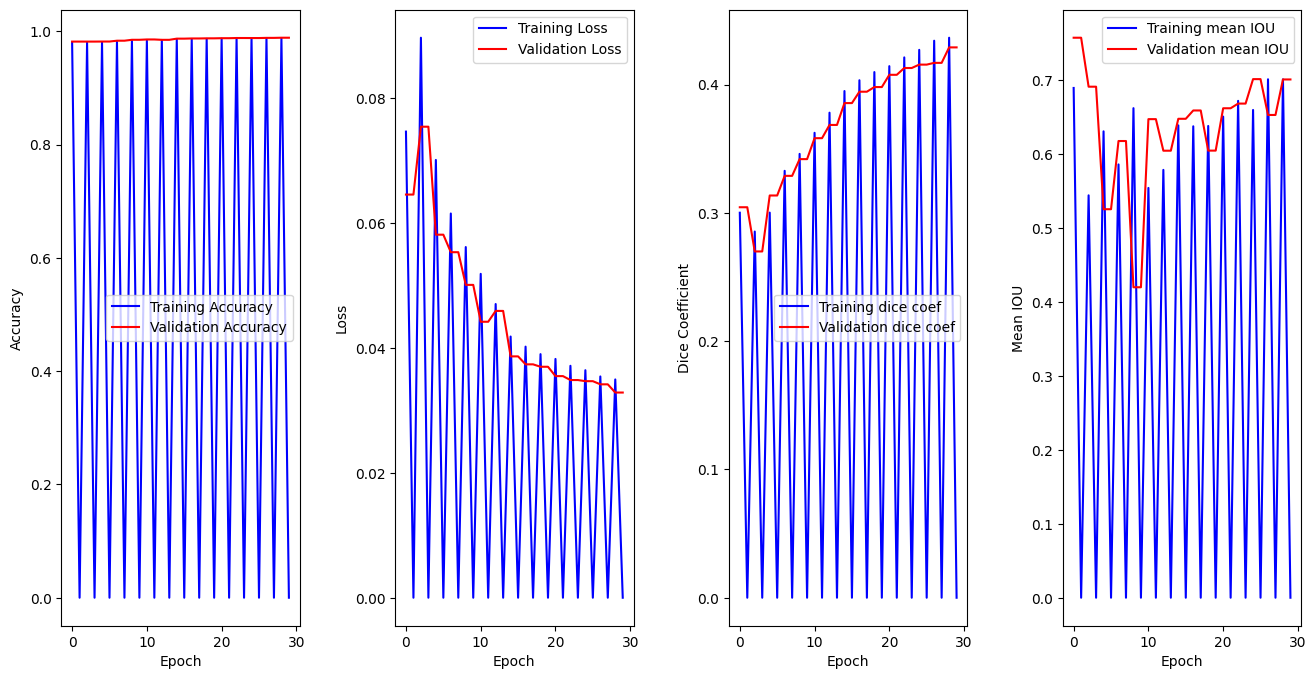

In [30]:
# Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
history = pd.read_csv('training.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(history['epoch'], history['dice_coef'], 'b', label='Training dice coef')
axs[2].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation dice coef')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

axs[3].plot(history['epoch'], history['mean_io_u'], 'b', label='Training mean IOU')
axs[3].plot(history['epoch'], history['val_mean_io_u'], 'r', label='Validation mean IOU')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Mean IOU')
axs[3].legend()

# Add space between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()

In [36]:
# Compile a model and load our saved weights
# IMG_SIZE = 128
# input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

# best_saved_model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

# best_saved_model.load_weights('model_.26-0.025329.m5')

In [31]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'
    #t1_path = sample_path + '_t1.nii'
    #t2_path = sample_path + '_t2.nii'
            
    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()
    
    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
    # Send our images to the CNN model and return predicted segmentation 
    return model.predict(X/np.max(X), verbose=1)

In [32]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)
    
    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)
    
    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)
   
    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()
    
    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')
    
    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')
    
    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')
    
    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')
    
    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')
    
    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 574ms/step
Patient number:  BraTS20_Training_172


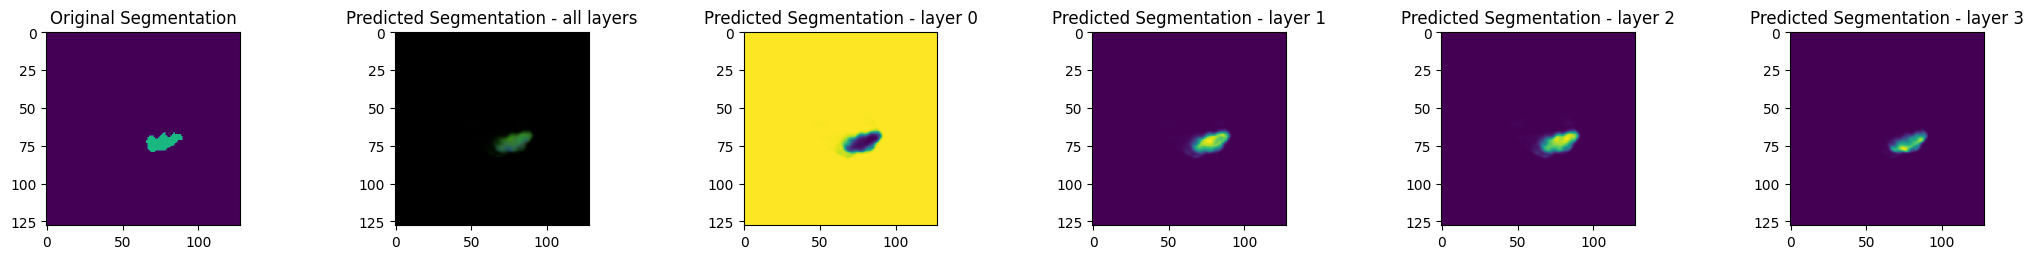

In [35]:
show_predicted_segmentations(samples_test, 60, cmap, norm)

In [37]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):
    
    # Get path of this patient
    sample_path = os.path.join(data_path, sample, sample)
    
    # Predict patient's segmentation
    predicted_seg = predict_segmentation(sample_path)
   
    # Load patient's original segmentation (Ground truth)
    seg_path = sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()
    
    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # Fix 4 to 3 to have the same values as in the predicted segmentation, and then same colors
    seg[seg==4] = 3
    
    # Remove background layer (0) from original segmentation
    seg[seg==0] = np.nan
    
    # Post-processing
    # Get indexes for each class of the highest probability pixels. Array will then contain only [0 1 2 3] instead of probabilities
    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]

    # Remove background layer (0) from post-processed predicted segmentation
    # To fix 0 to np.nan, we need to convert array as a float
    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan

    # Remove background layer (0) from classical predicted segmentation
    all = predicted_seg[slice_to_plot,:,:,1:4] 
    
    # Plot Original segmentation & predicted segmentation without processing & predicted segmentation
    print("Patient number: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    axstest[1].imshow(all)
    axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')
    
    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')
    
    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)
    
    plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step
Patient number:  BraTS20_Training_266


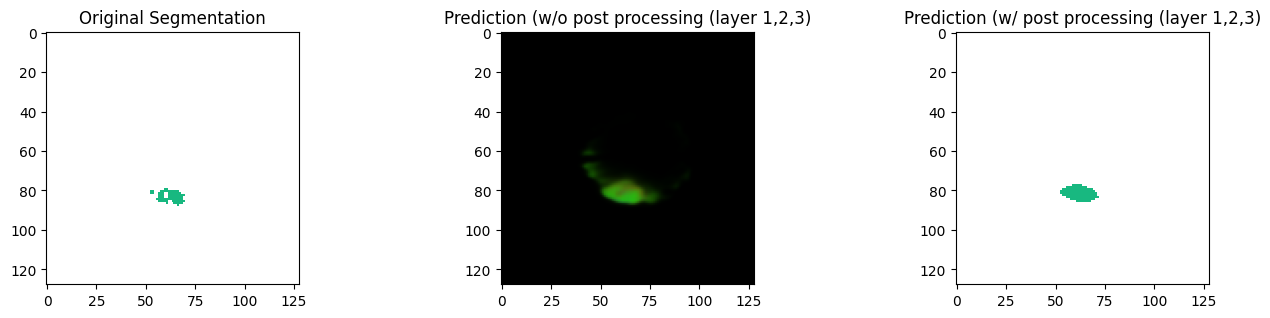

In [40]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=60, cmap=cmap, norm=norm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 526ms/step
Patient number:  BraTS20_Training_051


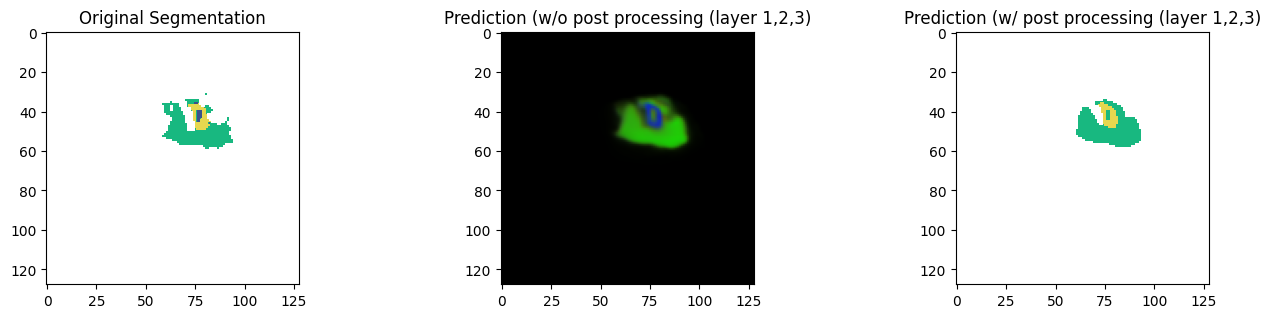

In [41]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=50, cmap=cmap, norm=norm)

In [42]:
# Evaluate the model on the test data

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9917 - dice_coef: 0.4371 - loss: 0.0270 - mean_io_u: 0.7039 - precision: 0.9940 - sensitivity: 0.9885 - specificity: 0.9979

Model evaluation on the test set:
Loss : 0.0306
Accuracy : 0.9901
MeanIOU : 0.7047
Dice coefficient : 0.4415
Precision : 0.993
Sensitivity : 0.9867
Specificity : 0.9976


In [2]:
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt
def get_predictions(t1ce_path, flair_path, slice_to_plot):
    
    t1_ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    X = np.empty((75, 240, 240, 2))
    for j in range(75):
        X[j, :, :, 0] = cv2.resize(flair[:,:,j + 60], (240, 240))
        X[j, :, :, 1] = cv2.resize(t1_ce[:,:,j + 60], (240, 240))
    
    predicted_seg = best_saved_model.predict(X/np.max(X), verbose=1)
    cmap_predict = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
    norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap_predict.N)  

    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]

    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan
    

    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    axs[0].imshow(t1_ce[:, :,100], cmap="gray")
    axs[0].set_title('T1_CE')
    axs[1].imshow(flair[:, :,100], cmap="gray")
    axs[1].set_title('flair')
    axs[2].imshow(my_pred, cmap, norm)
    axs[2].set_title('Predicton')

    plt.subplots_adjust(wspace=0.8)
    plt.show()
